<a href="https://colab.research.google.com/github/anyaconda/myStats/blob/master/mySpearmanSimulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Spearman Simulation

In [1]:
#meta 4/2/2021 Explore Spearman's Correlation - Daniel's Simulation

#history
#     4/3/2021 Add Continuous vs Categorical variables
#     Added vis

#     4/4/2021 Modified vis - added opacity to scatter plots
#     Opacity helps with visualizing data volumes

#     4/4/2021 Fixed: Analysis of Spearman Correlation - Dataset Not Ranked and Ranked
#     Fix: previously did sorting, but really needed to do ranking
#     Spearman correlation does ranking internally, so no need to pre-rank the dataset

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import scipy.stats as ss
from scipy.stats import spearmanr
from scipy.stats import pearsonr

In [3]:
#DIFINE GLOBAL VARS AND FUNCTIONS

# manually: Spearman's correlation without tied ranks
def rho1(x1,x2) -> np.float32:
    
    _n = len(x1)
    
    #rank input vars
    _x1_rank = len(x1)+1 - ss.rankdata(x1)
    _x2_rank = len(x2)+1 - ss.rankdata(x2)
    #print(_x1_rank, _x2_rank)
    
    #calc distance, squared distance
    _d = _x1_rank - _x2_rank
    _d_sqrd = _d**2
    #print(_d, _d_sqrd, _d_sqrd.sum())
    
    nom = 6 * _d_sqrd.sum()
    denom = _n * (_n**2 -1)
    #print(nom, denom)
    
    return (1 - (nom/denom))
 
 # manually: Spearman's correlation with tied ranks
def rho2(x1,x2) -> np.float32:
    #rank input vars
    _x1_rank = len(x1)+1 - ss.rankdata(x1)
    _x2_rank = len(x2)+1 - ss.rankdata(x2)
    #print(_x1_rank, _x2_rank)
    
    #calc mean ranking
    _mean_x1_rank = _x1_rank.mean()
    _mean_x2_rank = _x2_rank.mean()
    #print(_mean_x1_rank, _mean_x2_rank)
    
    #calc distance (rank - mean rank)
    _d_x1 = _x1_rank - _mean_x1_rank
    _d_x2 = _x2_rank - _mean_x2_rank
    #print(_d_x1, _d_x2)
    
    #nominator
    nom = (_d_x1 * _d_x2).sum()
    #denominator
    denom = np.sqrt((_d_x1**2).sum() * (_d_x2**2).sum())
    #print(nom, denom)
    
    return nom / denom

## Data Setup
Continuous Target, Categorical Label

In [4]:
true_target = np.arange(0,5000) / 4999
label = []

dist = {0:250,
       0.25:1000,
       0.5:2500,
       0.75:1000,
       1:250}

for lab, rep in dist.items():
    label.extend([lab]*rep)
label = np.array(label)
label.min(), label.max(), label.mean()

(0.0, 1.0, 0.5)

In [5]:
#categorical label
unique, counts = np.unique(label, return_counts=True)
unique, counts

(array([0.  , 0.25, 0.5 , 0.75, 1.  ]), array([ 250, 1000, 2500, 1000,  250]))

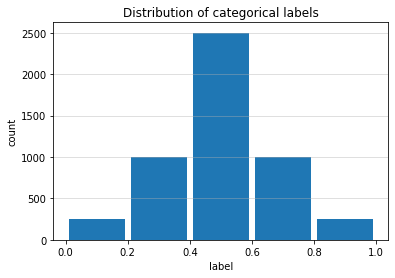

In [6]:
#vis categorical labels
plt.hist(label, bins=5, rwidth=0.9)
plt.xlabel('label')
plt.ylabel('count')
plt.title('Distribution of categorical labels')
plt.grid(axis='y', alpha=0.5)

# Some Simple Test Cases
## Case 1: Exactly Correct Predictions (Continuous)
(note: no identical scores => no tie)  
Perfect correlation in perfect order.  
This is just to make sure the most obvious case works as anticipated.

In [7]:
#Spearman vs Pearson
#Continuous predictions, Continuous target 
preds = np.arange(0,5000) / 4999
print('Spearman: ', spearmanr(preds, true_target))
print('Pearson: ', pearsonr(preds, true_target))

Spearman:  SpearmanrResult(correlation=0.9999999999999999, pvalue=0.0)
Pearson:  (1.0, 0.0)


In [8]:
# calculate spearman's correlation with Scipy
coef, p = spearmanr(preds, true_target)
print('Spearmans correlation coefficient:', coef)
# interpret the significance
alpha = 0.05
if p > alpha:
    print('Samples are uncorrelated (fail to reject H0) p=%.4f' % p)
else:
    print('Samples are correlated (reject H0) p=%.4f' % p)

Spearmans correlation coefficient: 0.9999999999999999
Samples are correlated (reject H0) p=0.0000


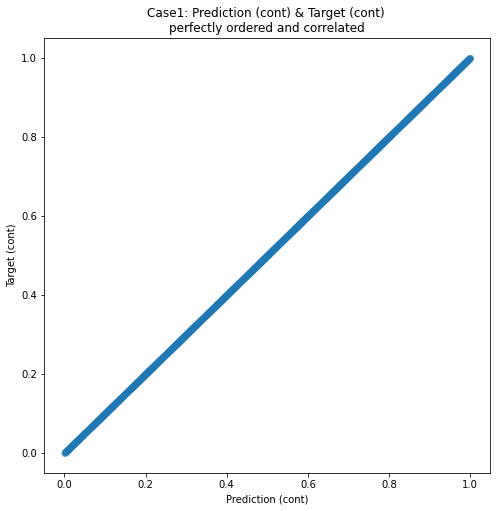

In [9]:
#visualize raw input already perfectly ordered and correlated
plt.figure(figsize=(8,8))
plt.scatter(preds, true_target, alpha=.1);
plt.title("Case1: Prediction (cont) & Target (cont) \nperfectly ordered and correlated");
plt.xlabel('Prediction (cont)');
plt.ylabel('Target (cont)');


## Case 2: Randomized (Continuous)
(note: no identical scores => no tie)  
Another mostly-obvious case - same predicitions in random order.

In [10]:
#save original predictions
preds_original = preds.copy()
#shuffle predictions (in place)
np.random.shuffle(preds)
#rank randomized predictions
true_target_ranked = len(true_target)+1 - ss.rankdata(true_target)
preds_ranked = len(preds)+1 - ss.rankdata(preds)

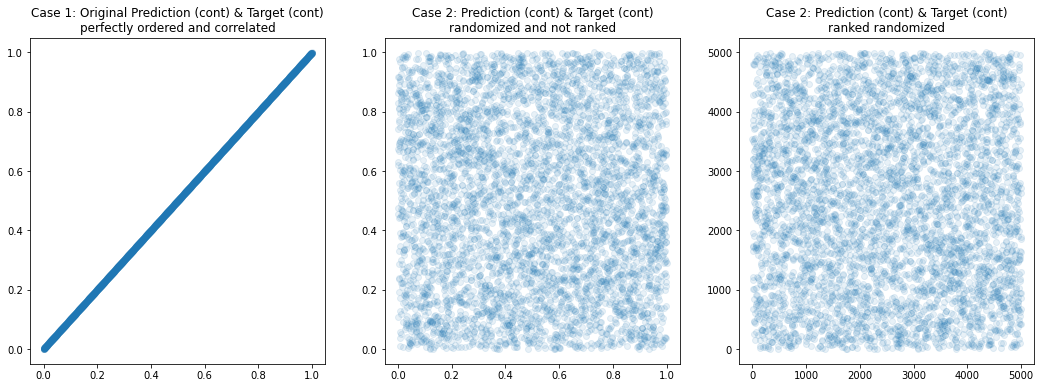

In [11]:
#visualize original input vs randomized input (not ranked and ranked)
_,ax = plt.subplots(1,3, figsize=(18,6))
ax[0].scatter(preds_original, true_target, alpha=.1);
ax[0].title.set_text("Case 1: Original Prediction (cont) & Target (cont)\nperfectly ordered and correlated");
ax[1].scatter(preds, true_target, alpha=.1);
ax[1].title.set_text("Case 2: Prediction (cont) & Target (cont)\nrandomized and not ranked");
ax[2].scatter(preds_ranked, true_target_ranked,  alpha=.1);
ax[2].title.set_text("Case 2: Prediction (cont) & Target (cont)\nranked randomized");

In [12]:
#Spearman vs Pearson
#Continuous predictions, Continuous target 
print('Original Spearman: ', spearmanr(preds_original, true_target))
print('Original Pearson: ', pearsonr(preds_original, true_target))
print('Randomized Spearman: ', spearmanr(preds, true_target))
print('Randomized Pearson: ', pearsonr(preds, true_target))
print('Randomized Spearman - ranked: ', spearmanr(preds_ranked, true_target_ranked))
print('Randomized Pearson - ranked: ', pearsonr(preds_ranked, true_target_ranked))

Original Spearman:  SpearmanrResult(correlation=0.9999999999999999, pvalue=0.0)
Original Pearson:  (1.0, 0.0)
Randomized Spearman:  SpearmanrResult(correlation=-0.016569512150780487, pvalue=0.24142641832925385)
Randomized Pearson:  (-0.0165695121507805, 0.24142641833379083)
Randomized Spearman - ranked:  SpearmanrResult(correlation=-0.016569512150780487, pvalue=0.24142641832925385)
Randomized Pearson - ranked:  (-0.01656951215078049, 0.24142641833379083)


> Observation: Spearman works without explicit ranking -> no need to pre-rank data.

In [13]:
# calculate spearman's correlation with Scipy
coef, p = spearmanr(preds, true_target)
print('Spearmans correlation coefficient:', coef)
# interpret the significance
alpha = 0.05
if p > alpha:
    print('Samples are uncorrelated (fail to reject H0) p=%.4f' % p)
else:
    print('Samples are correlated (reject H0) p=%.4f' % p)

Spearmans correlation coefficient: -0.016569512150780487
Samples are uncorrelated (fail to reject H0) p=0.2414


#### Randomized - confirm with manual rho1
(note: no identical scores => no tie) 

In [14]:
#confirm with my manual rho1 - rounding error probably due to implementation
rho1(preds, true_target)

-0.016569512150780508

Now we have the simplest of baselines:    
Case 1. The spearman correlation of an ordered array with itself is 1;  
Case 2. The spearman correlation of an ordered array with that same array randomly shuffled is less than 1, it's no longer perfectly correlated.  

### Daniel's Experiment - avg spearman correlation
of randomized predictions is close to 0.  

What degree of ordering could we expect by shuffling our predictions?


In [15]:
preds = np.arange(0,5000) / 4999
shuffle_corr = []
for i in range(5000):
    np.random.shuffle(preds)
    shuffle_corr.append(spearmanr(preds,true_target)[0])

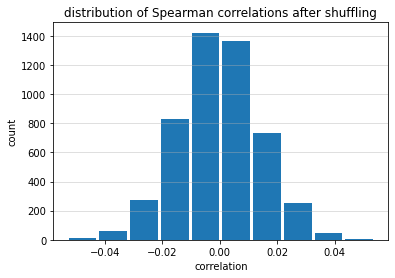

In [16]:
shuffle_corr = np.array(shuffle_corr)
plt.hist(shuffle_corr, bins=10, rwidth=0.9)
plt.xlabel('correlation')
plt.ylabel('count')
plt.title('distribution of Spearman correlations after shuffling')
plt.grid(axis='y', alpha=0.5)

> The average spearman correlation of an ordered array with that same array randomly shuffled reaches zero.

## Case 3: Categorical Predictions, All 5 Classes
(note: identical results by label => tied ranks)  
What happens if we try to get the correlation with only five values? Basically, if the labels (0, 0.25, ..., 1) are the predictions?

In [17]:
#Continuous target, Categorical predictions
preds = label
print('Spearman: ', spearmanr(preds, true_target))
print('Pearson: ', pearsonr(preds, true_target))

Spearman:  SpearmanrResult(correlation=0.9266876681762855, pvalue=0.0)
Pearson:  (0.9101511045617652, 0.0)


> Observation: Pearson starts to deviate from Spearman

In [18]:
coef, p = spearmanr(preds, true_target)
print('Spearmans correlation coefficient:', coef)
# interpret the significance
alpha = 0.05
if p > alpha:
    print('Samples are uncorrelated (fail to reject H0) p=%.4f' % p)
else:
    print('Samples are correlated (reject H0) p=%.4f' % p)

Spearmans correlation coefficient: 0.9266876681762855
Samples are correlated (reject H0) p=0.0000


In [19]:
#confirm with my manual rho2 - rounding error probably due to implementation (note: rho1 result is different here)
rho2(preds, true_target)

0.9266876681762855

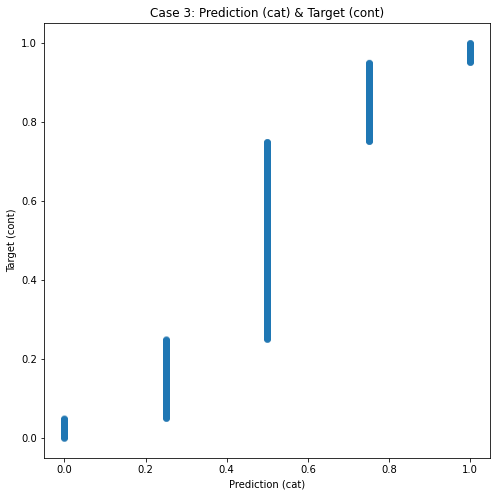

In [20]:
#visualize raw input (already ordered) -> correlation is not perfect but still statistically significant
plt.figure(figsize=(8,8))
plt.scatter(preds, true_target, alpha=.1);
plt.title("Case 3: Prediction (cat) & Target (cont)");
plt.xlabel('Prediction (cat)');
plt.ylabel('Target (cont)');

Interesting -- still an extremely high correlation, but not exactly 1.

## Case 3a: Categorical Predictions Randomized - All 5 Classes (Continuous) 
(note: again no identical scores => no tie)



Now the real question: what if the results *within each label* are shuffled? That is, if we correctly predict each label, but then within each label we randomly order the results? Let's construct a DataFrame to better visualize.

In [21]:
#shuffle predictions
labelcat = pd.Categorical(label)
df = pd.DataFrame({'Label':labelcat, 'true_target':true_target, 'pred':np.zeros_like(true_target)})

In [22]:
#Continuous predictions, randomized withing category
pred = []
for label in df.Label.unique():
    ordered = df.loc[df.Label==label, 'true_target']
    shuffled = list(ordered)
    np.random.shuffle(shuffled)
    pred.extend(shuffled)

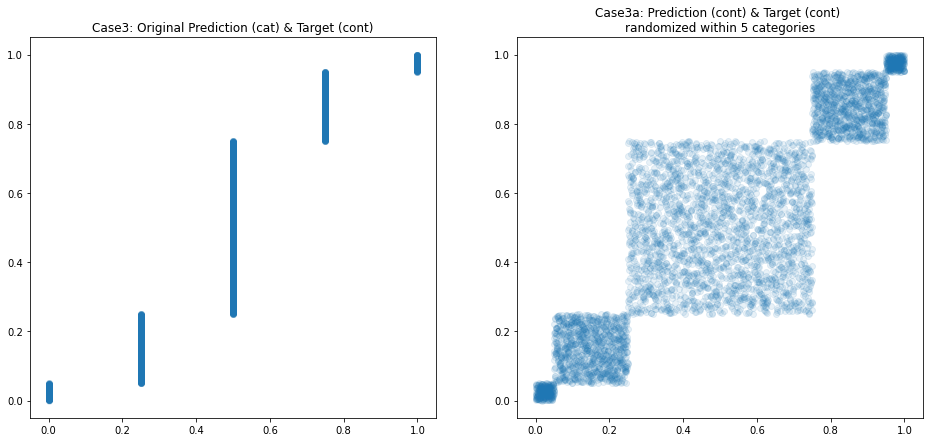

In [23]:
#visualize original (categorical pred) and randomized (continuous pred) -> correlation is not perfect but still statistically significant
_,ax = plt.subplots(1,2, figsize=(16,7))
ax[0].scatter(preds, true_target, alpha=.1);
ax[0].title.set_text("Case3: Original Prediction (cat) & Target (cont)");
ax[1].scatter(pred, true_target, alpha=.1);
ax[1].title.set_text("Case3a: Prediction (cont) & Target (cont) \nrandomized within 5 categories");

The below test show that `pred` is not ordered, BUT that the preds in each category are lower than the preds in each subsequent category. (check: not comprehensive?)

In [24]:
all(pred[i] <= pred[i+1] for i in range(len(pred)-1)), np.all(pred[0:250] < pred[250:1250]), np.mean(pred[0:250]), np.mean(pred[4750:])

(False, True, 0.02490498099619924, 0.9750950190038009)

In [25]:
#preview - preds randomized
#pred[:10] #not ordered

#each category stats - min, max, mean
(min(pred[:250]), max(pred[:250]), np.mean(pred[:250])), (min(pred[250:1250]), max(pred[250:1250]), np.mean(pred[250:1250])), (min(pred[1250:3750]), max(pred[1250:3750]), np.mean(pred[1250:3750])), (min(pred[3750:4750]), max(pred[3750:4750]), np.mean(pred[3750:4750])), (min(pred[4750:]), max(pred[4750:]), np.mean(pred[4750:]))


((0.0, 0.04980996199239848, 0.02490498099619924),
 (0.05001000200040008, 0.2498499699939988, 0.14992998599719942),
 (0.2500500100020004, 0.7499499899979996, 0.5),
 (0.7501500300060012, 0.9499899979995999, 0.8500700140028005),
 (0.9501900380076015, 1.0, 0.9750950190038009))

In [26]:
coef, p = spearmanr(pred, true_target)
print('Spearmans correlation coefficient:', coef)
# interpret the significance
alpha = 0.05
if p > alpha:
    print('Samples are uncorrelated (fail to reject H0) p=%.4f' % p)
else:
    print('Samples are correlated (reject H0) p=%.4f' % p)

Spearmans correlation coefficient: 0.8607301640292063
Samples are correlated (reject H0) p=0.0000


In [27]:
#confirm with my manual rho1, check rho2 also - interestingly rho2 is identical to rho1
rho1(pred, true_target), rho2(pred, true_target)

(0.8607301640292065, 0.8607301640292065)

### Daniel's Experiment - avg spearman correlation
of randomized predictions is close to the dataset correlation (both continous predictions)

What degree of ordering could we expect by shuffling our predictions?

Let's try this shuffling process a bunch of times and take the correlations.

In [28]:
df = pd.DataFrame({'Label':labelcat, 'true_target':true_target})
corrs = []
for i in range(10000):
    pred=[]
    for label in df.Label.unique():
        ordered = df.loc[df.Label==label, 'true_target']
        shuffled = list(ordered)
        np.random.shuffle(shuffled)
        #np.flip(shuffled)
        pred.extend(shuffled)
    corrs.append(spearmanr(pred,true_target)[0])

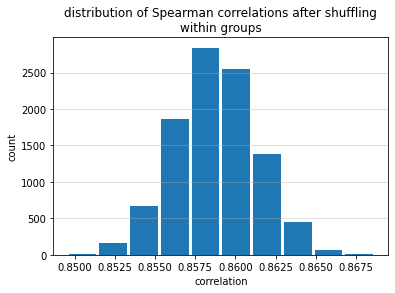

In [29]:
group_shuffle_corr = np.array(corrs)
plt.hist(group_shuffle_corr, bins=10, rwidth=0.9)
plt.xlabel('correlation')
plt.ylabel('count')
plt.title('distribution of Spearman correlations after shuffling\nwithin groups')
plt.grid(axis='y', alpha=0.5)

In [30]:
np.mean(corrs)

0.8587419228984607

## Case 4: Categorical Predictions  - Only 2 Classes
(note: identical results by label => tied ranks)  
What happens if we try to get the correlation with only 2 values? Basically, if the labels ('low','high') are the predictions?

In [31]:
true_target = np.arange(0,5000) / 4999
label = []

dist = {'low': 3500,
        'high':1500}

for lab, rep in dist.items():
    label.extend([lab]*rep)
label = np.array(label)
label

array(['low', 'low', 'low', ..., 'high', 'high', 'high'], dtype='<U4')

In [32]:
#Continuous target, Categorical predictions
preds = label
print('Spearman: ', spearmanr(preds, true_target))
#print('Pearson: ', pearsonr(preds, true_target)) #Pearson doesn't work with string values

Spearman:  SpearmanrResult(correlation=-0.7937254091938855, pvalue=0.0)


In [33]:
coef, p = spearmanr(preds, true_target)
print('Spearmans correlation coefficient:', coef)
# interpret the significance
alpha = 0.05
if p > alpha:
    print('Samples are uncorrelated (fail to reject H0) p=%.4f' % p)
else:
    print('Samples are correlated (reject H0) p=%.4f' % p)

Spearmans correlation coefficient: -0.7937254091938855
Samples are correlated (reject H0) p=0.0000


In [34]:
#confirm with my manual rho2 - rounding error probably due to implementation (note: rho1 result is different here)
rho2(preds, true_target)

-0.7937254091938855

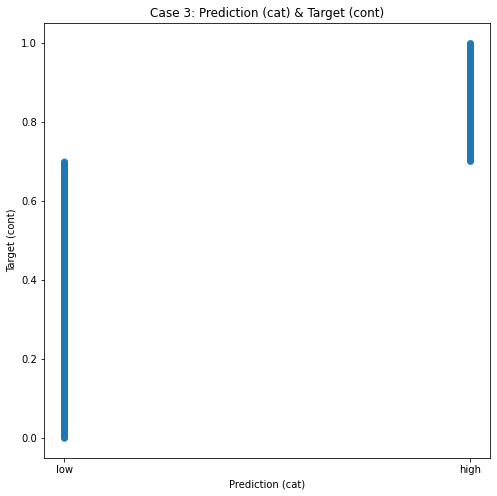

In [35]:
#visualize raw input (already ordered) -> correlation is not perfect but still statistically significant
plt.figure(figsize=(8,8))
plt.scatter(preds, true_target, alpha=.1);
plt.title("Case 3: Prediction (cat) & Target (cont)");
plt.xlabel('Prediction (cat)');
plt.ylabel('Target (cont)');

## Case 4a: Categorical Predictions Randomized - Only 2 Classes   (Continuous) 
(note: again no identical scores => no tie)

In [36]:
labelcat = pd.Categorical(label)
df = pd.DataFrame({'Label':labelcat, 'true_target':true_target})
corrs = []
for i in range(5000):
    pred=[]
    for label in df.Label.unique():
        ordered = df.loc[df.Label==label, 'true_target']
        shuffled = list(ordered)
        np.random.shuffle(shuffled)
        #np.flip(shuffled)
        pred.extend(shuffled)
    corrs.append(spearmanr(pred,true_target)[0])

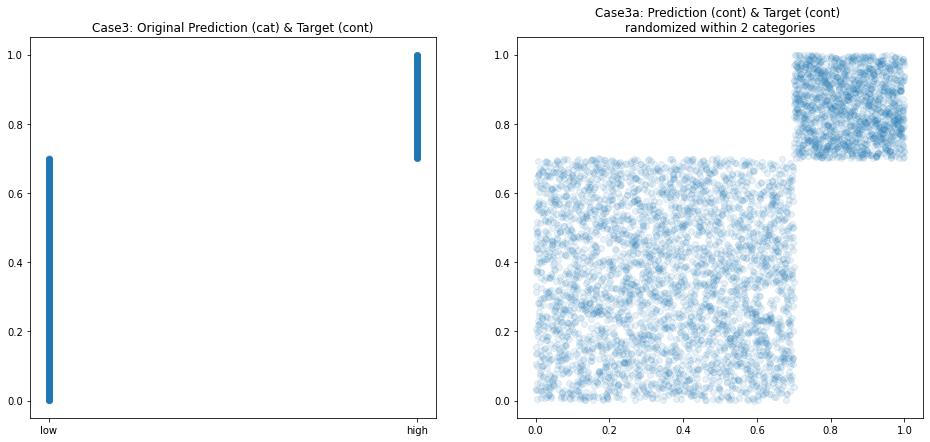

In [37]:
#visualize original (categorical pred) and randomized (continuous pred) -> correlation is not perfect but still statistically significant
_,ax = plt.subplots(1,2, figsize=(16,7))
ax[0].scatter(preds, true_target, alpha=.1);
ax[0].title.set_text("Case3: Original Prediction (cat) & Target (cont)");
ax[1].scatter(pred, true_target, alpha=.1);
ax[1].title.set_text("Case3a: Prediction (cont) & Target (cont) \nrandomized within 2 categories");

In [38]:
#preview - preds randomized
#pred[:10] #not ordered

#each category stats - min, max, mean
(min(pred[:3500]), max(pred[:3500]), np.mean(pred[:3500])),  (min(pred[3500:]), max(pred[3500:]), np.mean(pred[3500:]))


((0.0, 0.6999399879975995, 0.34996999399879974),
 (0.7001400280056012, 1.0, 0.8500700140028006))

In [39]:
coef, p = spearmanr(pred, true_target)
print('Spearmans correlation coefficient:', coef)
# interpret the significance
alpha = 0.05
if p > alpha:
    print('Samples are uncorrelated (fail to reject H0) p=%.4f' % p)
else:
    print('Samples are correlated (reject H0) p=%.4f' % p)

Spearmans correlation coefficient: 0.6221062372042494
Samples are correlated (reject H0) p=0.0000


In [40]:
#confirm with my manual rho1, check rho2 also - interestingly rho2 is identical to rho1
rho1(pred, true_target), rho2(pred, true_target)

(0.6221062372042495, 0.6221062372042495)

### Daniel's Experiment - avg spearman correlation
of randomized predictions is close to the dataset correlation (both continous predictions)

What degree of ordering could we expect by shuffling our predictions with two classes only?

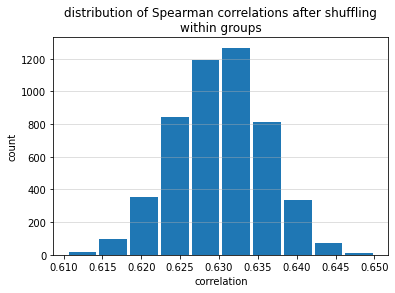

In [41]:
group_shuffle_corr = np.array(corrs)
plt.hist(group_shuffle_corr, bins=10, rwidth=0.9)
plt.xlabel('correlation')
plt.ylabel('count')
plt.title('distribution of Spearman correlations after shuffling\nwithin groups')
plt.grid(axis='y', alpha=0.5)

In [42]:
np.mean(group_shuffle_corr)

0.6301217042298345

> Conclusion: looks Spearman correlation of categorical and continuous values don't jibe together.